In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


# Building the model

Text(0.5, 1.0, 'Shape: (32, 32, 3)')

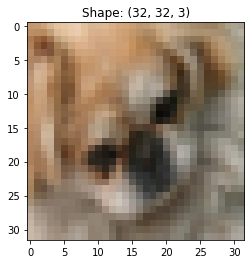

In [2]:
# load data and split it into Test, train and validation sets

(X_1, y_1), (X_2, y_2) = tf.keras.datasets.cifar10.load_data()
X = np.vstack((X_1, X_2))
y = np.vstack((y_1, y_2))
X_train, X, y_train, y = train_test_split(X, y, train_size=0.8, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5, stratify=y)

assert X_test.shape == X_valid.shape, 'X_test and X_valid have different shapes'
for i in range(10):
    assert np.count_nonzero(keras.utils.to_categorical(y_train)[:, i]) == 4800 , 'Sample is not stratified'
sample_shape = X_train[0].shape
plt.imshow(X_train[1])
plt.title(f'Shape: {sample_shape}')

In [3]:
# normalize the data
# it would be better to use keras.utils.normalize for this, but then it would be impossible to de-normalize the data

X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

In [158]:
# build the model

model = Sequential()
model.add(Input(shape=sample_shape))
model.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model.add(UpSampling2D())
model.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 12)      

In [ ]:
# train the model
history = model.fit(X_train, X_train, validation_data=(X_valid, X_valid), epochs=10, verbose=1, use_multiprocessing=True)

In [54]:
model.evaluate(X_test, X_test)


188/188 [==============================] - 3s 11ms/step - loss: 0.0040 - mean_absolute_error: 0.0445 - cosine_similarity: 0.9914


[0.004018696956336498, 0.04449302703142166, 0.9913666248321533]

In [55]:
predictions = model.predict(X_train, verbose=1)

1500/1500 [==============================] - 14s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


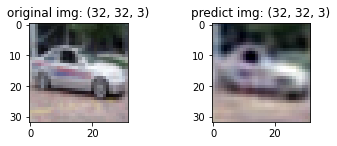

In [90]:
def plot_img_compare(model, data, img_nr):
    """Plot original image next to predicted image 

    Args:
        model (model accepting.predict() method): the model to predict
        data (np.array): the whole data stack
        img_nr (int): the index of to use for image plot.
    """
    assert type(img_nr) == int, 'wrong dtype for img_nr'
    predictions = model.predict(data)
    pred_img = predictions[img_nr]
    plt.subplot(221).imshow(data[img_nr])
    plt.subplot(221).set_title(f'original img: {data[img_nr].shape}')
    plt.subplot(222).imshow(pred_img)
    plt.subplot(222).set_title(f'predict img: {predictions[img_nr].shape}')
    plt.show()

plot_img_compare(model, X_test, 1)

In [97]:
def save_model(model, path = 'models/CAE'):
    model.save(path)
def load_model(path = 'models/CAE'):
    return keras.models.load_model(path)
model = load_model()

In [4]:
# learn model for b-w version of the images

to_grayscale = lambda x: x[:,:,:,0]/3 + x[:,:,:,1]/3 + x[:,:,:,2]/3

X_train_bw = to_grayscale(X_train)
X_test_bw = to_grayscale(X_test)
X_valid_bw = to_grayscale(X_valid)

In [5]:
X_train_bw = X_train_bw[:,:,:,np.newaxis]
X_test_bw = X_test_bw[:,:,:,np.newaxis]
X_valid_bw = X_valid_bw[:,:,:,np.newaxis]


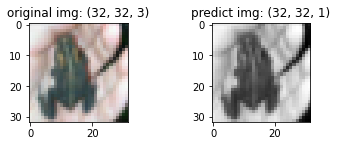

In [6]:
def comp_rgb_bw(rgb_img, gray_img):
    plt.subplot(221).imshow(rgb_img)
    plt.subplot(221).set_title(f'original img: {rgb_img.shape}')
    plt.subplot(222).imshow(gray_img, cmap='gray')
    plt.subplot(222).set_title(f'predict img: {gray_img.shape}')
    plt.show()
comp_rgb_bw(X_train[0], X_train_bw[0])

In [44]:
# build the model_bw

model_bw = Sequential()
model_bw.add(Input(shape=X_train_bw[0].shape))
model_bw.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(Conv2D(12, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D(size=(2,2)))
model_bw.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(6,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(1,(3,3), padding='same', activation='relu'))


# compile the model_bw
model_bw.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_bw.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 12)        876       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 12)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 16, 16, 16)        1744      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 8, 8, 32)        

In [45]:
history_bw = model_bw.fit(X_train_bw, X_train_bw, epochs=7, validation_data=(X_valid_bw, X_valid_bw), verbose=1, use_multiprocessing=True)

Epoch 1/2
1500/1500 [==============================] - 175s 116ms/step - loss: 0.0083 - mean_absolute_error: 0.0575 - cosine_similarity: 0.9980 - val_loss: 0.0038 - val_mean_absolute_error: 0.0434 - val_cosine_similarity: 0.9986
Epoch 2/2
1500/1500 [==============================] - 176s 117ms/step - loss: 0.0035 - mean_absolute_error: 0.0413 - cosine_similarity: 0.9977 - val_loss: 0.0034 - val_mean_absolute_error: 0.0414 - val_cosine_similarity: 0.9961


In [46]:
model_bw.evaluate(X_test_bw, X_test_bw)

188/188 [==============================] - 5s 27ms/step - loss: 0.0034 - mean_absolute_error: 0.0416 - cosine_similarity: 0.9970


[0.003407752141356468, 0.041581299155950546, 0.996958315372467]

In [47]:
predictions_bw = model_bw.predict(X_train_bw, verbose=1)

In [73]:
predictions_bw.shape
X_train_comb = np.concatenate((predictions, predictions_bw),3)

In [82]:
# build model_comb for combination of prediction model_comb

model_comb = Sequential()
model_comb.add(Input(shape=X_train_comb[0].shape))
model_comb.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D(size=(2,2)))
model_comb.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D())
model_comb.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model_comb
model_comb.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_comb.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 32, 32, 8)         296       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d_34 (UpSampling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 16, 16, 12)      

In [83]:
history_comb = model_comb.fit(X_train_comb, X_train, epochs=7, verbose=1, use_multiprocessing=True)

Epoch 1/7
1500/1500 [==============================] - 52s 34ms/step - loss: 0.0134 - mean_absolute_error: 0.0769 - cosine_similarity: 0.9834
Epoch 2/7
1500/1500 [==============================] - 51s 34ms/step - loss: 0.0062 - mean_absolute_error: 0.0568 - cosine_similarity: 0.9917
Epoch 3/7
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0057 - mean_absolute_error: 0.0542 - cosine_similarity: 0.9921
Epoch 4/7
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0054 - mean_absolute_error: 0.0526 - cosine_similarity: 0.9921
Epoch 5/7
1500/1500 [==============================] - 52s 34ms/step - loss: 0.0052 - mean_absolute_error: 0.0516 - cosine_similarity: 0.9921
Epoch 6/7
1500/1500 [==============================] - 49s 33ms/step - loss: 0.0051 - mean_absolute_error: 0.0508 - cosine_similarity: 0.9921
Epoch 7/7
1500/1500 [==============================] - 53s 35ms/step - loss: 0.0050 - mean_absolute_error: 0.0502 - cosine_similarity: 0.9920


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


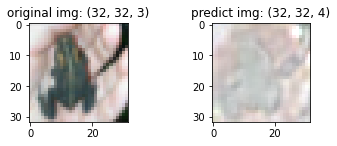

In [86]:
predict_comb = model_comb.predict(X_train_comb)

def comp_comb_org(comb_img, org_img):
    plt.subplot(221).imshow(org_img)
    plt.subplot(221).set_title(f'original img: {org_img.shape}')
    plt.subplot(222).imshow(comb_img)
    plt.subplot(222).set_title(f'predict img: {comb_img.shape}')
    plt.show()


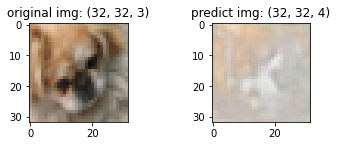

In [87]:
comp_rgb_bw(X_train[1], X_train_comb[1])

In [99]:
save_model(model_comb, 'models/model_pipe_comb')
save_model(model_bw, 'models/model_pipe_bw')

INFO:tensorflow:Assets written to: models/model_pipe_comb/assets
INFO:tensorflow:Assets written to: models/model_pipe_bw/assets
